In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
import lightgbm as lgb
from tqdm import tqdm_notebook
import joblib
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows

60

In [2]:
path = r'C:\\Users\\lixue\\OneDrive\\Desktop\\smu\\MQF\\Quantitative Research\\project_part2\\'
#df = pd.read_csv(path+'yearly_data.csv')
df = pd.read_excel(path+'2020.xlsx')
print(df)

      all_us_stocks                            company_name  period  \
0      NasdaqGS:AAL            American Airlines Group Inc.  FY2020   
1     NasdaqGS:AAON                              AAON, Inc.  FY2020   
2     NasdaqGS:AAPL                              Apple Inc.  FY2020   
3     NasdaqGS:AAWW      Atlas Air Worldwide Holdings, Inc.  FY2020   
4     NasdaqGS:ABCB                          Ameris Bancorp  FY2020   
...             ...                                     ...     ...   
4642       NYSE:ZTS                             Zoetis Inc.  FY2020   
4643       NYSE:ZUO                             Zuora, Inc.  FY2020   
4644      NYSE:ZVIA                               Zevia PBC  FY2020   
4645       NYSE:ZWS  Zurn Elkay Water Solutions Corporation  FY2020   
4646      NYSE:ZYME                          Zymeworks Inc.  FY2020   

      IQ_RD_EXP  IQ_TOTAL_ASSETS  RnD_OVER_TA                industry  \
0         0.000        62008.000     0.000000             Industrials   
1

In [3]:
'''
cols = df.iloc[0,:]
df.set_axis(cols,axis=1,inplace=True)
df = df.iloc[1:,:]
df.reset_index(drop=True,inplace=True)
'''
df['RnD_OVER_TA'] = pd.to_numeric(df['RnD_OVER_TA'], errors='coerce')
df.columns.values[0] = "company"
df.replace('NM', np.nan,inplace=True)
df.replace('', np.nan,inplace=True)
df.replace(' ', np.nan,inplace=True)
tmp = np.where(df['RnD_OVER_TA']>0,df['RnD_OVER_TA'],0)
df.replace('0', np.nan,inplace=True)
df.replace(0, np.nan,inplace=True)
df['RnD_OVER_TA_CAT'] = tmp
df.head()

,company,company_name,period,IQ_RD_EXP,IQ_TOTAL_ASSETS,RnD_OVER_TA,industry,IQ_RETURN_ASSETS,IQ_RETURN_CAPITAL,IQ_RETURN_EQUITY,...,IQ_GP_3YR_ANN_CAGR,IQ_EBITDA_3YR_ANN_CAGR,IQ_EARNING_CO_3YR_ANN_CAGR,IQ_NI_3YR_ANN_CAGR,IQ_EPS_3YR_ANN_CAGR,IQ_ACCT_RECV_3YR_ANN_CAGR,IQ_NPPE_3YR_ANN_CAGR,IQ_COMMON_EQUITY_3YR_ANN_CAGR,IQ_TOTAL_ASSETS_3YR_ANN_CAGR,RnD_OVER_TA_CAT
0,NasdaqGS:AAL,American Airlines Group Inc.,FY2020,NaN,62008.000,NaN,Industrials,-11.3296,-20.4838,NaN,...,NaN,NaN,NaN,NaN,NaN,-8.5032,5.1475,NaN,5.5145,0.000000
1,NasdaqGS:AAON,"AAON, Inc.",FY2020,NaN,449.008,NaN,Industrials,14.8508,18.9604,24.6516,...,8.0195,11.0015,13.6451,13.6451,13.8383,-1.9936,16.4642,13.9355,14.7994,0.000000
2,NasdaqGS:AAPL,Apple Inc.,FY2020,18752.0,323888.000,0.057897,Information Technology,12.5089,21.4578,73.6855,...,5.9748,2.6530,5.8920,5.8920,12.5187,-3.3843,10.3015,-21.3006,-4.7939,0.057897
3,NasdaqGS:AAWW,"Atlas Air Worldwide Holdings, Inc.",FY2020,NaN,6029.188,NaN,Industrials,5.5472,6.4844,17.7755,...,14.5482,21.2435,17.1066,17.2575,15.8612,10.9369,2.0650,8.1090,6.7558,0.000000
4,NasdaqGS:ABCB,Ameris Bancorp,FY2020,NaN,20438.638,NaN,Financials,1.3546,NaN,10.2405,...,NaN,NaN,52.7227,52.7227,23.9440,NaN,NaN,48.7366,37.5349,0.000000


In [4]:
df.describe()

,IQ_RD_EXP,IQ_TOTAL_ASSETS,RnD_OVER_TA,IQ_RETURN_ASSETS,IQ_RETURN_CAPITAL,IQ_RETURN_EQUITY,IQ_RETURN_INVESTED_CAPITAL,IQ_RETURN_COMMON_EQUITY,IQ_GROSS_MARGIN,IQ_EBITDA_MARGIN,...,IQ_GP_3YR_ANN_CAGR,IQ_EBITDA_3YR_ANN_CAGR,IQ_EARNING_CO_3YR_ANN_CAGR,IQ_NI_3YR_ANN_CAGR,IQ_EPS_3YR_ANN_CAGR,IQ_ACCT_RECV_3YR_ANN_CAGR,IQ_NPPE_3YR_ANN_CAGR,IQ_COMMON_EQUITY_3YR_ANN_CAGR,IQ_TOTAL_ASSETS_3YR_ANN_CAGR,RnD_OVER_TA_CAT
count,1.246000e+03,4.292000e+03,1246.000000,4135.000000,3628.000000,3951.000000,3626.000000,3751.000000,3626.000000,3108.000000,...,3015.000000,2230.000000,2087.000000,2062.000000,2012.000000,2973.000000,2724.000000,3240.000000,3580.000000,4647.000000
mean,3.288792e+03,1.001001e+06,0.226338,-3.840734,-4.456946,-46.883132,-19.703648,-3.766811,47.020922,10.336410,...,7.703625,6.612572,13.594303,14.567916,13.453162,9.649260,28.361572,10.602573,16.517664,0.060688
std,4.260579e+04,1.813078e+07,3.326316,205.380205,171.945650,1956.118739,313.144686,245.299627,37.835637,43.174589,...,45.425150,36.765729,51.720530,54.331970,55.633132,41.032386,66.148349,61.208546,95.760130,1.724820
min,1.931900e-01,2.500000e-02,0.000178,-13071.427900,-9698.086300,-120922.000000,-16731.270300,-3242.205100,-299.940100,-284.960700,...,-75.306100,-91.608100,-86.451500,-88.863900,-92.662800,-87.243200,-87.880800,-85.793900,-47.772200,0.000000
25%,2.260725e+01,5.748545e+02,0.023680,-0.608700,-1.417575,-11.680700,-11.379850,-9.583600,25.782000,4.085575,...,-4.076350,-6.200250,-9.783150,-9.069600,-9.606100,-5.173900,3.737225,-2.689775,0.332300,0.000000
50%,6.135000e+01,2.324807e+03,0.063912,1.802400,2.806200,4.403800,-0.860850,5.047700,44.380000,14.153050,...,3.169700,3.601200,6.413800,6.682900,6.222550,3.798900,13.324600,4.679100,7.019300,0.000000
75%,1.949967e+02,1.029055e+04,0.138377,4.455050,6.637500,12.074800,5.279025,12.566400,71.238700,28.524150,...,11.904200,15.084825,23.217250,22.791775,22.167975,15.207600,35.031100,14.133350,17.093800,0.006172
max,1.098736e+06,6.107199e+08,114.509385,669.371900,1696.628300,6575.944000,2714.605400,10794.227300,100.119400,131.689900,...,1786.056700,922.251200,619.867100,617.505700,627.952200,709.623700,1867.387800,2126.072300,4759.050700,114.509385


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4647 entries, 0 to 4646
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   company                          4647 non-null   object 
 1   company_name                     4647 non-null   object 
 2   period                           4647 non-null   object 
 3   IQ_RD_EXP                        1246 non-null   float64
 4   IQ_TOTAL_ASSETS                  4292 non-null   float64
 5   RnD_OVER_TA                      1246 non-null   float64
 6   industry                         4647 non-null   object 
 7   IQ_RETURN_ASSETS                 4135 non-null   float64
 8   IQ_RETURN_CAPITAL                3628 non-null   float64
 9   IQ_RETURN_EQUITY                 3951 non-null   float64
 10  IQ_RETURN_INVESTED_CAPITAL       3626 non-null   float64
 11  IQ_RETURN_COMMON_EQUITY          3751 non-null   float64
 12  IQ_GROSS_MARGIN     

In [6]:
Y = df.iloc[:,5:6]
X = df.iloc[:,6:]

In [7]:
df['RnD_OVER_TA_CAT']

0       0.000000
1       0.000000
2       0.057897
3       0.000000
4       0.000000
          ...   
4642    0.034022
4643    0.184965
4644    0.000000
4645    0.000000
4646    0.000000
Name: RnD_OVER_TA_CAT, Length: 4647, dtype: float64

In [8]:
tmp = np.where(df['RnD_OVER_TA']>0,1,0)
Y_cat = pd.DataFrame(tmp,columns  = ['RnD_OVER_TA'])
Y_cat

,RnD_OVER_TA
0,0
1,0
2,1
3,0
4,0
...,...
4642,1
4643,1
4644,0
4645,0


### Data set EDA

<AxesSubplot:xlabel='RnD_OVER_TA', ylabel='count'>

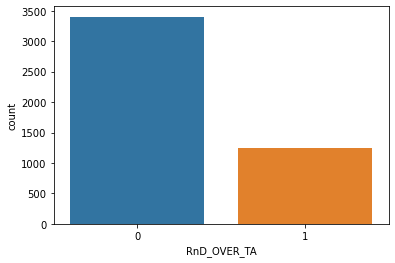

In [9]:
# see portion of companies in each quater with R&D Expanse
sns.countplot('RnD_OVER_TA',data = Y_cat)

In [10]:
X.columns

Index(['industry', 'IQ_RETURN_ASSETS', 'IQ_RETURN_CAPITAL', 'IQ_RETURN_EQUITY',
       'IQ_RETURN_INVESTED_CAPITAL', 'IQ_RETURN_COMMON_EQUITY',
       'IQ_GROSS_MARGIN', 'IQ_EBITDA_MARGIN', 'IQ_EARNING_CO_MARGIN',
       'IQ_NI_MARGIN', 'IQ_LFCF_MARGIN', 'IQ_FIXED_ASSET_TURNS', 'IQ_AR_TURNS',
       'IQ_CURRENT_RATIO', 'IQ_QUICK_RATIO', 'IQ_DAYS_SALES_OUT',
       'IQ_DAYS_PAYABLE_OUT', 'IQ_CFO_CURRENT_LIAB', 'IQ_TOTAL_DEBT_EQUITY',
       'IQ_TOTAL_DEBT_CAPITAL', 'IQ_LT_DEBT_EQUITY', 'IQ_LT_DEBT_CAPITAL',
       'IQ_TOTAL_LIAB_TOTAL_ASSETS', 'IQ_EBITDA_CAPEX_INT',
       'IQ_NET_DEBT_EBITDA_CAPEX', 'IQ_Z_SCORE', 'IQ_CAPEX_PCT_REV',
       'IQ_TOTAL_REV_1YR_ANN_GROWTH', 'IQ_GP_1YR_ANN_GROWTH',
       'IQ_EBITDA_1YR_ANN_GROWTH', 'IQ_EARNING_CO_1YR_ANN_GROWTH',
       'IQ_NI_1YR_ANN_GROWTH', 'IQ_EPS_1YR_ANN_GROWTH',
       'IQ_ACCT_RECV_1YR_ANN_GROWTH', 'IQ_NPPE_1YR_ANN_GROWTH',
       'IQ_COMMON_EQUITY_1YR_ANN_GROWTH', 'IQ_TOTAL_ASSETS_1YR_ANN_GROWTH',
       'IQ_CFO_1YR_ANN_GROWTH', 'I

In [11]:
#X['IQ_RETURN_ASSETS'].plot(kind='hist',bins=100,figsize=(15,5),title='distr of IQ_RETURN_ASSETS')

In [12]:
'''
item = 'IQ_RETURN_ASSETS'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
df.loc[df['RD_EXP_CAT']==1][item].plot(kind='hist',
                                       bins=100,
                                       title = f'{item} RE_EXP_CAT = 1',
                                       ax=ax1)

df.loc[df['RD_EXP_CAT']==0][item].plot(kind='hist',
                                       bins=100,
                                       title = f'{item} RE_EXP_CAT = 0',
                                       ax = ax2)

plt.show()
'''

"\nitem = 'IQ_RETURN_ASSETS'\nfig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))\ndf.loc[df['RD_EXP_CAT']==1][item].plot(kind='hist',\n                                       bins=100,\n                                       title = f'{item} RE_EXP_CAT = 1',\n                                       ax=ax1)\n\ndf.loc[df['RD_EXP_CAT']==0][item].plot(kind='hist',\n                                       bins=100,\n                                       title = f'{item} RE_EXP_CAT = 0',\n                                       ax = ax2)\n\nplt.show()\n"

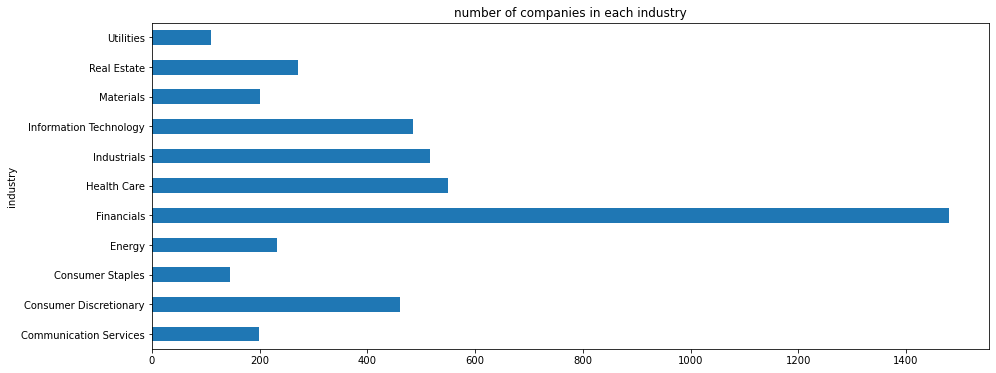

In [13]:
df.groupby('industry')['company'].count().plot(kind='barh',
                                          figsize=(15,6),
                                          title = 'number of companies in each industry')

plt.show()

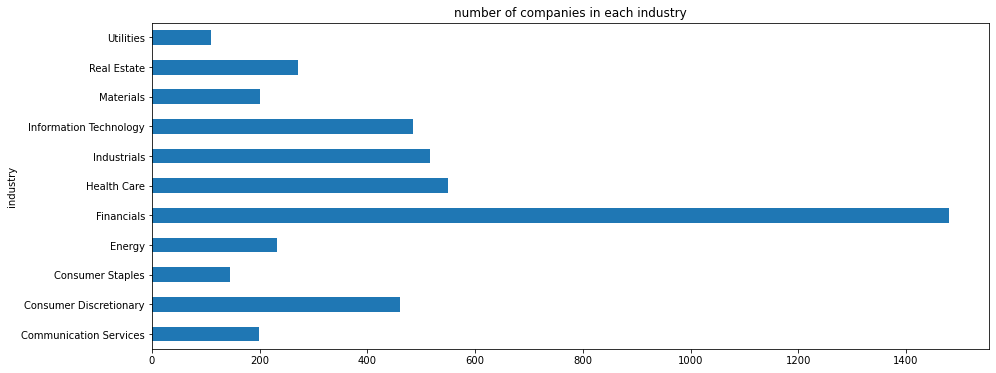

In [14]:
df.groupby('industry')['RnD_OVER_TA_CAT'].count().plot(kind='barh',
                                          figsize=(15,6),
                                          title = 'number of companies in each industry')

plt.show()

In [15]:
### LabelEncoder convert categorical type data
i = 0
for col in df.columns:
    if df[col].dtype == "object":
        print(col)
        i = i+1
print(i)

company
company_name
period
industry
4


In [16]:
### count number of NaN, if more than 30%, remove such column
def clean_nan(df):
    tmp_cols = []
    for col in df.columns:
        counter = df[col].isnull().sum()
        ratio = counter / len(df[col])
        if ratio > 0.3:
            tmp_cols.append(col)
    print(tmp_cols)     
    new_df = df.drop(tmp_cols,axis=1)
    return new_df

In [17]:
### count number of zero, if more than 30%, remove such column
def clean_zero(df):
    tmp_cols = []
    for col in df.columns:
        counter = (df[col] == 0).sum()
        ratio = counter / len(df[col])
        if ratio > 0.3:
            tmp_cols.append(col)     
    new_df = df.drop(tmp_cols,axis=1)
    print(tmp_cols)
    return new_df

In [18]:
# Delete rows containing either 30% or more than 30% NaN Values
perc = 30.0 # Here N is 75
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
#df = df.dropna( axis=0, 
                    #thresh=min_count)

In [19]:
print('original shape: ',df.shape)
#df = clean_nan(df)

original shape:  (4647, 66)


In [20]:
### for those columns with majority element that is 
### more than 90% of the whole column, remove the column

def clean_top_cols(df):
    cols_to_remove = [col for col in df.columns if df[col].value_counts(dropna=False,normalize=True).values[0]>0.9]
    return cols_to_remove

In [21]:
#col_to_remove = clean_top_cols(df)
#len(col_to_remove)

In [22]:
### note dont remove the target col
#col_to_remove

In [23]:
#df = df.drop(col_to_remove,axis=1)


In [24]:
### LabelEncoder
encoder = LabelEncoder()

#encoder.fit(list(df['industry'].values))
#df['industry'] = encoder.transform(list(df['industry'].values))

#encoder.fit(list(df['period'].values))
#df['period'] = encoder.transform(list(df['period'].values))

encoder.fit(list(df['company'].values))
df['company'] = encoder.transform(list(df['company'].values))

        
df = df.reset_index()

In [25]:
cols = ['industry_Communication Services','industry_Consumer Discretionary','industry_Consumer Staples',
        'industry_Energy','industry_Financials','industry_Health Care','industry_Industrials','industry_Information Technology',
        'industry_Materials','industry_Real Estate','industry_Utilities']
tmp2 = pd.get_dummies(pd.DataFrame(df['industry']))[cols]
df = pd.concat([df,tmp2],axis=1)
RnD_OVER_TA_CAT_tmp = df['IQ_RD_EXP']
df = df.drop('RnD_OVER_TA_CAT', axis=1)
df['RnD_OVER_TA_CAT'] = RnD_OVER_TA_CAT_tmp
'''
df = df.drop(['industry','company_name','IQ_EBITA_MARGIN','IQ_EBIT_MARGIN','IQ_NI_NORM_MARGIN'
              ,'IQ_NI_AVAIL_EXCL_MARGIN','IQ_UFCF_MARGIN','IQ_ASSET_TURNS','IQ_EBIT_INT','IQ_EBITDA_INT'
              ,'IQ_TOTAL_DEBT_EBITDA','IQ_NET_DEBT_EBITDA','IQ_TOTAL_DEBT_EBITDA_CAPEX','IQ_EBITA_1YR_ANN_GROWTH'
              ,'IQ_EBIT_1YR_ANN_GROWTH','IQ_NI_NORM_1YR_ANN_GROWTH'], axis=1)
              
'''




"\ndf = df.drop(['industry','company_name','IQ_EBITA_MARGIN','IQ_EBIT_MARGIN','IQ_NI_NORM_MARGIN'\n              ,'IQ_NI_AVAIL_EXCL_MARGIN','IQ_UFCF_MARGIN','IQ_ASSET_TURNS','IQ_EBIT_INT','IQ_EBITDA_INT'\n              ,'IQ_TOTAL_DEBT_EBITDA','IQ_NET_DEBT_EBITDA','IQ_TOTAL_DEBT_EBITDA_CAPEX','IQ_EBITA_1YR_ANN_GROWTH'\n              ,'IQ_EBIT_1YR_ANN_GROWTH','IQ_NI_NORM_1YR_ANN_GROWTH'], axis=1)\n              \n"

In [26]:
#fill with column mean values
df = df.apply(pd.to_numeric, errors='coerce')
df.dtypes
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
df = df.drop(['company_name','industry','period','RnD_OVER_TA','IQ_RD_EXP'],axis=1)
df = df.drop(df[df.RnD_OVER_TA_CAT == 0].index)

In [27]:
df.to_csv('2020_rmse.csv')

#### 